In [5]:
# organize imports
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import normalize
from keras.callbacks import Callback
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from keras.models import load_model
from keras.utils import plot_model

from sklearn.model_selection import train_test_split
import keras.backend as K
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
import random
import pydot
import tensorflow as tf


In [6]:
# seed for reproducing same results
seed = 9
np.random.seed(seed)


# Helper functions below

## Load data and create test and training inputs and outputs

In [7]:
# filenames must be a list
def loadData(filenames, validationRatio = 0.10, testRatio = 0.25, fieldNames = ["train_input_collected", "train_output_collected"]):
    # load simple dataset
    for i, filename in enumerate(filenames):
        PATH_FILE_TRAINING3 = os.getcwd()+"/"+filename
        f = h5py.File(PATH_FILE_TRAINING3, "r")
        # split into input and output variables
        if i==0:
            X       = f[fieldNames[0]].value;     
            X      = X.transpose();
            Y        = f[fieldNames[1]].value;      
            Y       = Y.transpose();
        else:
            X1       = f[fieldNames[0]].value;     
            X1      = X1.transpose();
            Y1        = f[fieldNames[1]].value;      
            Y1       = Y1.transpose();
            X = np.vstack((X,X1))
            Y = np.vstack((Y,Y1))   
    # Take out some data (10%) to save for validation
    (X_rest, X_valid, Y_rest, Y_valid) = train_test_split(X, Y, test_size=validationRatio, random_state=seed)
    # split the remaining data into training (75%) and testing (25%)
    (X_train, X_test, Y_train, Y_test) = train_test_split(X_rest, Y_rest, test_size=testRatio, random_state=seed)

    # Examine shape of data
#     print(np.shape(X))
#     print(np.shape(Y))
#     print(np.shape(X_valid))
#     print(np.shape(Y_valid))
#     print(np.shape(X_train))
#     print(np.shape(X_test))
#     print(np.shape(Y_train))
#     print(np.shape(Y_test))
    return X_train, X_test, X_valid, Y_train, Y_test, Y_valid



In [8]:
def saveSplitDataValidTrainTest(filename, X_train_norm, X_test_norm, X_valid_norm, Y_train_norm, Y_test_norm, Y_valid_norm):
    # Save these into an h5 file
    hf = h5py.File(filename, 'w')
    hf.create_dataset("X_train_norm", data = X_train_norm)
    hf.create_dataset("X_test_norm", data = X_test_norm)
    hf.create_dataset("X_valid_norm", data = X_valid_norm)
    hf.create_dataset("Y_train_norm", data = Y_train_norm)
    hf.create_dataset("Y_test_norm", data = Y_test_norm)
    hf.create_dataset("Y_valid_norm", data = Y_valid_norm)
    hf.close()

In [9]:
def loadSplitDataValidTrainTest(filename):
    hf = h5py.File(filename, "r")
    X_train_norm = np.array(hf.get("X_train_norm"))
    X_test_norm = np.array(hf.get("X_test_norm"))
    X_valid_norm = np.array(hf.get("X_valid_norm"))
    Y_train_norm = np.array(hf.get("Y_train_norm"))
    Y_test_norm = np.array(hf.get("Y_test_norm"))
    Y_valid_norm = np.array(hf.get("Y_valid_norm"))
    hf.close() 
    return X_train_norm, X_test_norm, X_valid_norm, Y_train_norm, Y_test_norm, Y_valid_norm

## Create custom metric to print learning rate after each epoch

In [10]:
class CustomMetrics(Callback):
    def on_epoch_end(self, epoch, logs=None):
        current_lr = K.eval(self.model.optimizer.lr)
        lrHist.append(current_lr)
        print("Learning rate: ",current_lr)
#     def on_batch_end(self, batch, logs):
#         weights, _biases = model.get_weights()
#         w1, w2 = weights
#         weights = [w1[0], w2[0]]
#         print('on_batch_end() model.weights:', weights)
#         weights_history.append(weights)

In [11]:
def plotCoeffsExpectedAndNN(Y, NN):
    # Y and NN have same shape (1,*) 
    xs = range(1,np.size(Y,0)+1)
    plt.scatter(xs, Y, color='r',marker='s', s = 30)
    plt.scatter(xs, NN, color='g', marker='^', s = 20)
    plt.title('Poly coeffs deviation from expected')
    plt.ylabel('Value of coeff')
    plt.xlabel('Coefficient number')
    plt.legend(['true coeffs', 'NN output coeffs'], loc='lower left')
    plt.show()

In [12]:
## Normalize dataset

In [13]:
def normalize_datasets(X_train, X_test, X_valid, Y_train, Y_test, Y_valid):
    # Normalize all datasets to be between [0,1]
#     xMin = np.amin(X, axis=0)
    xMin = np.array([0.0,0.0,0.5,   0.,0.,0.,  0.,0.,0., 1.,  0.,0.,0., 
           0.0,0.0,0.5,   0.,0.,0.,  0.,0.,1., 0.,  0.,0.,0.])
#     xMax = np.amax(X, axis=0)
    xMax = np.array([10.0,10.0,0.5,   0.,0.,0.,  0.,0.,0., 1.,  0.,0.,0., 
           10.0,10.0,0.5,   0.,0.,0.,  0.,0.,1., 0.,  0.,0.,0.])
    xRange = xMax - xMin
    
    xRange[xRange == 0] = 1.0
    xRange[abs(xRange) <1.0e-20]=1.0
    X_train_norm = (X_train-xMin)/xRange
    X_test_norm = (X_test-xMin)/xRange
    X_valid_norm = (X_valid-xMin)/xRange

    Y = np.vstack([Y_train, Y_test, Y_valid])
    yMin = np.amin(Y, axis=0)
    yMax = np.amax(Y, axis=0)
    yRange = yMax - yMin
    yRange[yRange == 0] = 1.0
    yRange[abs(yRange) <1.0e-20]=1.0
    Y_train_norm = (Y_train-yMin)/yRange
    Y_test_norm = (Y_test-yMin)/yRange
    Y_valid_norm = (Y_valid-yMin)/yRange
    
    return (X_train_norm, Y_train_norm,X_test_norm, Y_test_norm,X_valid_norm, Y_valid_norm, xMin, xRange, yMin, yRange)

In [14]:
def saveDataParamsToHDF5(filename, xMin, yMin, xRange, yRange):
    # Save these params into an h5 file
    hf = h5py.File(filename, 'w')
    hf.create_dataset("xMin", data = xMin)
    hf.create_dataset("yMin", data = yMin)
    hf.create_dataset("xRange", data = xRange)
    hf.create_dataset("yRange", data = yRange)
    hf.close()

In [15]:
def getDataParamsFromHDF5(filename):
    hf = h5py.File(filename, "r")
    xMin = np.array(hf.get("xMin"))
    yMin = np.array(hf.get("yMin"))
    xRange = np.array(hf.get("xRange"))
    yRange = np.array(hf.get("yRange"))
    hf.close() 
    return xMin, yMin, xRange, yRange

In [16]:
def getDataParamsFromHDF5Old(filename):
    hf = h5py.File(filename, "r")
    xMin_train = np.array(hf.get("xMin_train"))
    yMin_train = np.array(hf.get("yMin_train"))
    xRange_train = np.array(hf.get("xRange_train"))
    yRange_train = np.array(hf.get("yRange_train"))
    xMin_test = np.array(hf.get("xMin_test"))
    yMin_test = np.array(hf.get("yMin_test"))
    xRange_test = np.array(hf.get("xRange_test"))
    yRange_test = np.array(hf.get("yRange_test"))
    xMin_valid = np.array(hf.get("xMin_valid"))
    yMin_valid = np.array(hf.get("yMin_valid"))
    xRange_valid = np.array(hf.get("xRange_valid"))
    yRange_valid = np.array(hf.get("yRange_valid"))
    hf.close() 
    return xMin_train, yMin_train, xRange_train, yRange_train, xMin_test, yMin_test, xRange_test, yRange_test, xMin_valid, yMin_valid, xRange_valid, yRange_valid

In [17]:
def saveDataParamsToHDF5Old(filename, xMin_train, yMin_train, xRange_train, yRange_train, xMin_test, yMin_test, xRange_test, yRange_test, xMin_valid, yMin_valid, xRange_valid, yRange_valid):
    # Save these params into an h5 file
    hf = h5py.File(filename, 'w')
    hf.create_dataset("xMin_train", data = xMin_train)
    hf.create_dataset("yMin_train", data = yMin_train)
    hf.create_dataset("xRange_train", data = xRange_train)
    hf.create_dataset("yRange_train", data = yRange_train)
    hf.create_dataset("xMin_test", data = xMin_test)
    hf.create_dataset("yMin_test", data = yMin_test)
    hf.create_dataset("xRange_test", data = xRange_test)
    hf.create_dataset("yRange_test", data = yRange_test)
    hf.create_dataset("xMin_valid", data = xMin_valid)
    hf.create_dataset("yMin_valid", data = yMin_valid)
    hf.create_dataset("xRange_valid", data = xRange_valid)
    hf.create_dataset("yRange_valid", data = yRange_valid)
    hf.close()

# Train on the polynomial coeffs for polygonal obstacles for new astrobeeSE3

In [18]:
(X_train, X_test, X_valid, Y_train, Y_test, Y_valid) = loadData(["../data_files/PolyAstrobeeCoeffs.jld2", "../data_files/PolyMoreCoeffs.jld2"], validationRatio = 0.1, testRatio = 0.25, fieldNames = ["train_input_collected", "all_coeffs"])
# Each input is of size 26
# Each output is of size 95
print(np.shape(X_valid))
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(Y_valid))
print(np.shape(Y_train))
print(np.shape(Y_test))

# X = np.vstack(X_valid, X_train, X_test)
# Y = np.vstack(Y_valid, Y_train, Y_test)

(X_train_norm, Y_train_norm,X_test_norm, Y_test_norm,X_valid_norm, Y_valid_norm, xMin, xRange, yMin, yRange) = normalize_datasets(X_train, X_test, X_valid, Y_train, Y_test, Y_valid)
print("")
print(np.shape(X_valid_norm))
print(np.shape(X_train_norm))
print(np.shape(X_test_norm))
print(np.shape(Y_valid_norm))
print(np.shape(Y_train_norm))
print(np.shape(Y_test_norm))


filename = "../data_files/PolyComboCoeffsNormalized.jld2"
saveSplitDataValidTrainTest(filename, X_train_norm, X_test_norm, X_valid_norm, 
                            Y_train_norm, Y_test_norm, Y_valid_norm)

filename = "../data_files/PolyComboParams.h5"
saveDataParamsToHDF5(filename, xMin, yMin, xRange, yRange)


(1130, 26)
(7625, 26)
(2542, 26)
(1130, 95)
(7625, 95)
(2542, 95)

(1130, 26)
(7625, 26)
(2542, 26)
(1130, 95)
(7625, 95)
(2542, 95)


/home/somrita/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [19]:
1130+7625+2542

11297

In [20]:
# create the model
model = Sequential()
model.add(Dense(128, input_dim=26, activation='relu'))
model.add(Dense(256, kernel_initializer='uniform', activation='relu'))
model.add(Dense(512, kernel_initializer='uniform', activation='relu'))
model.add(Dense(256, kernel_initializer='uniform', activation='relu'))
model.add(Dense(95, kernel_initializer='uniform', activation='relu'))

# compile the model
customAdam = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer=customAdam, metrics=['mean_squared_error'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=1e-50)

lrHist = []

In [21]:
# fit the model
histSimple = model.fit(X_train_norm, Y_train_norm, validation_data=(X_test_norm, Y_test_norm), epochs=30, batch_size=1, verbose=1, callbacks=[reduce_lr, CustomMetrics()])

# evaluate the model
scores = model.evaluate(X_test_norm, Y_test_norm)




Train on 7625 samples, validate on 2542 samples
Epoch 1/30





7625/7625 [==============================] - 33s 4ms/step - loss: 0.0795 - mean_squared_error: 0.0795 - val_loss: 0.0515 - val_mean_squared_error: 0.0515
Learning rate:  0.001
Epoch 2/30
7625/7625 [==============================] - 36s 5ms/step - loss: 0.0446 - mean_squared_error: 0.0446 - val_loss: 0.0431 - val_mean_squared_error: 0.0431
Learning rate:  0.001
Epoch 3/30
7625/7625 [==============================] - 36s 5ms/step - loss: 0.0417 - mean_squared_error: 0.0417 - val_loss: 0.0401 - val_mean_squared_error: 0.0401
Learning rate:  0.001
Epoch 4/30
7625/7625 [==============================] - 36s 5ms/step - loss: 0.0393 - mean_squared_error: 0.0393 - val_loss: 0.0331 - val_mean_squared_error: 0.0331
Learning rate:  0.001
Epoch 5/30
7625/7625 [==============================] - 34s 4ms/step - loss: 0.0330 - mean_squared_error: 0.0330 - val_loss: 0.0329 - val_mean_squared_error: 0.0329
Learning rate:  0.001
Epoch 6/3

In [37]:
# save history and learning rate
filename='../data_files/HistLearningRatePolyMore.h5'
hf = h5py.File(filename, 'w')
hf.create_dataset("history_loss", data = histSimple.history['loss'])
hf.create_dataset("history_val_loss", data = histSimple.history['val_loss'])
hf.create_dataset("lrHist", data = lrHist)
hf.close()

In [38]:
# fetch history and learning rate
filename='../data_files/HistLearningRatePolyMore.h5'
hf = h5py.File(filename, "r")
history_loss = np.array(hf.get("history_loss"))
history_val_loss = np.array(hf.get("history_val_loss"))
lrHist = np.array(hf.get("lrHist"))
hf.close() 

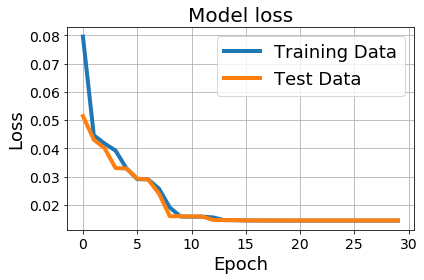

In [56]:
# summarize history for loss
plt.plot(history_loss, linewidth=4)
plt.plot(history_val_loss, linewidth=4)
plt.title('Model loss', fontsize = 20)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Loss', fontsize = 18)
plt.legend(['Training Data', 'Test Data'], loc='upper right', fontsize = 18)
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.show()
plt.tight_layout()
plt.savefig('losshistory-new.png')

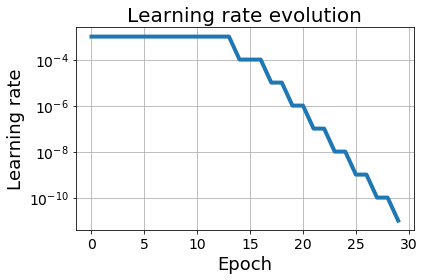

In [57]:
# show evolution of learning rate
plt.plot(lrHist, linewidth = 4)
plt.title('Learning rate evolution', fontsize = 20)
plt.ylabel('Learning rate', fontsize = 18)
plt.xlabel('Epoch', fontsize = 18)
plt.yscale('log')
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.show()
plt.tight_layout()
plt.savefig('learningrateevolution-new.png')

In [31]:
hf.close()

In [19]:
# save model to hdf5 file
model.save('../data_files/PolyCombo.h5') 

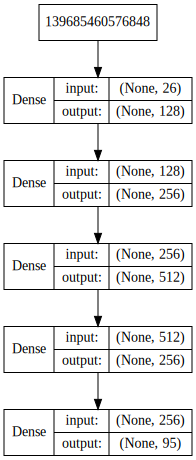

In [49]:
# plot_model(model, to_file='NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1IterBiggerNetwork.png')
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

model = load_model('../data_files/PolyCombo.h5')
SVG(model_to_dot(model, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))

In [21]:
model = load_model('../data_files/PolyCombo.h5')

# serialize model to JSON
model_json = model.to_json()
with open("../data_files/PolyCombo.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("../data_files/PolyComboWeights.h5")
print("Saved model to disk")

file = h5py.File('../data_files/PolyComboWeights.h5', 'r')
print(list(file.keys()))
file.close()

Saved model to disk
[u'dense_1', u'dense_2', u'dense_3', u'dense_4', u'dense_5']


# Run model on some inputs and plot results

### Try training data

In [22]:
model = load_model('../data_files/PolyCombo.h5')
# This won't randomize as long as seed doesn't change. 
# (X_train, X_test, Y_train, Y_test) = loadData(["../data_files/PolyAstrobeeCoeffs.jld2"], testRatio = 0.25, fieldNames = ["train_input_collected", "train_output_collected"])

# To be safe, let's do this instead
filename = "../data_files/PolyComboCoeffsNormalized.jld2"
(X_train_norm, X_test_norm, X_valid_norm, 
 Y_train_norm, Y_test_norm, Y_valid_norm) = loadSplitDataValidTrainTest(filename)

filename = "../data_files/PolyComboParams.h5"
(xMin, yMin, xRange, yRange) = getDataParamsFromHDF5(filename)

In [23]:
Idx = [0,1,2,3,700]
NN_input = np.array(X_train_norm)
NN_output_norm = model.predict(NN_input[Idx])
NN_output = NN_output_norm*yRange + yMin

In [39]:
stPoints = (NN_input[Idx][:,0:3])*xRange[0:3] + xMin[0:3]
endPoints = NN_input[Idx][:,13:16]*xRange[0:3] + xMin[0:3]
print(stPoints)
print(endPoints)

[[4.44444444 8.88888889 0.5       ]
 [0.5        6.125      0.5       ]
 [1.375      8.         0.5       ]
 [0.9375     8.         0.5       ]]
[[10.          7.77777778  0.5       ]
 [ 9.          2.75        0.5       ]
 [ 5.5         4.4375      0.5       ]
 [ 7.5         2.1875      0.5       ]]


Training Examples


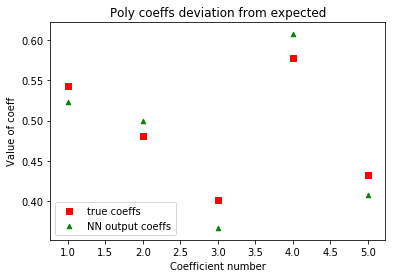

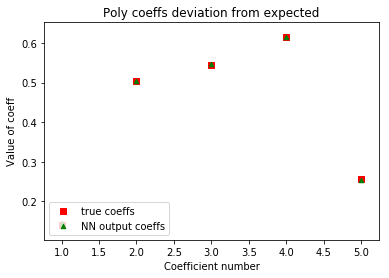

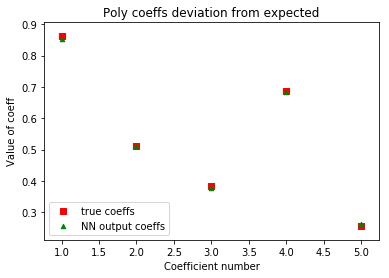

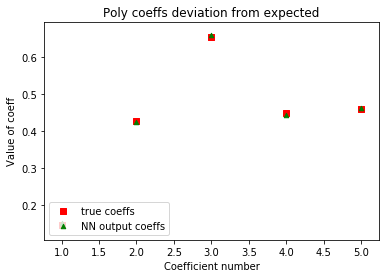

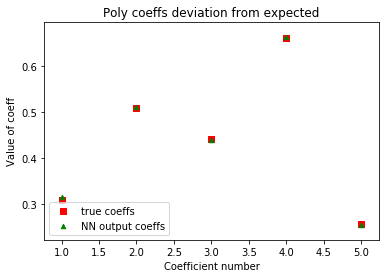

In [24]:
print("Training Examples")
for NN_idx, train_idx in enumerate(Idx):
    true_X_coeff_norm = Y_train_norm[train_idx,0:5]
    NN_X_coeff_norm = NN_output_norm[NN_idx,0:5]
    plotCoeffsExpectedAndNN(true_X_coeff_norm, NN_X_coeff_norm)
    print("")


### Try test data

In [41]:
Idx = [61,83,100, 123]
NN_input = np.array(X_test_norm)
NN_output_norm = model.predict(NN_input[Idx])
NN_output = NN_output_norm*yRange + yMin


In [42]:
stPoints = (NN_input[Idx][:,0:3])*xRange[0:3] + xMin[0:3]
endPoints = NN_input[Idx][:,13:16]*xRange[0:3] + xMin[0:3]
print(stPoints)
print(endPoints)

[[ 1.8125      7.0625      0.5       ]
 [ 2.22222222 10.          0.5       ]
 [ 2.25        5.8125      0.5       ]
 [ 3.125       7.6875      0.5       ]]
[[9.         5.         0.5       ]
 [6.66666667 0.         0.5       ]
 [9.5        2.1875     0.5       ]
 [9.5        3.875      0.5       ]]


Test Examples


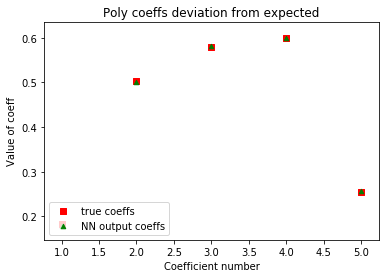

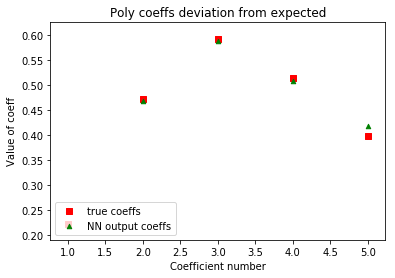

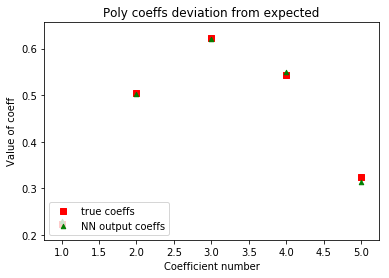

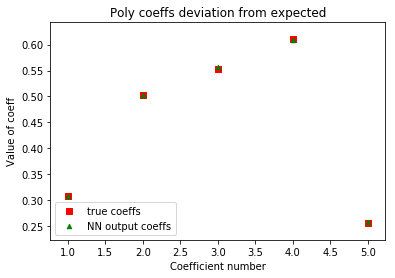

In [43]:
print("Test Examples")
for NN_idx, test_idx in enumerate(Idx):
    true_X_coeff_norm = Y_test_norm[test_idx,0:5]
    NN_X_coeff_norm = NN_output_norm[NN_idx,0:5]
    plotCoeffsExpectedAndNN(true_X_coeff_norm, NN_X_coeff_norm)
    print("")


### Try validation data

In [45]:
Idx = [61,83,100, 101]
NN_input = np.array(X_valid_norm)
NN_output_norm = model.predict(NN_input[Idx])
NN_output = NN_output_norm*yRange + yMin


In [48]:
print(np.shape(Y_valid_norm))

(1130, 95)


In [46]:
stPoints = (NN_input[Idx][:,0:3])*xRange[0:3] + xMin[0:3]
endPoints = NN_input[Idx][:,13:16]*xRange[0:3] + xMin[0:3]
print(stPoints)
print(endPoints)

[[4.44444444 8.88888889 0.5       ]
 [0.5        6.125      0.5       ]
 [1.375      8.         0.5       ]
 [0.9375     8.         0.5       ]]
[[10.          7.77777778  0.5       ]
 [ 9.          2.75        0.5       ]
 [ 5.5         4.4375      0.5       ]
 [ 7.5         2.1875      0.5       ]]


Validation Examples


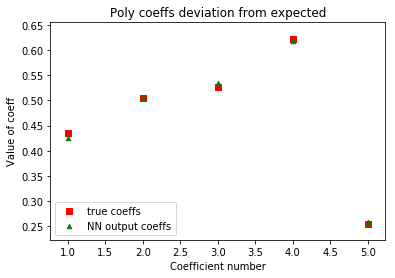

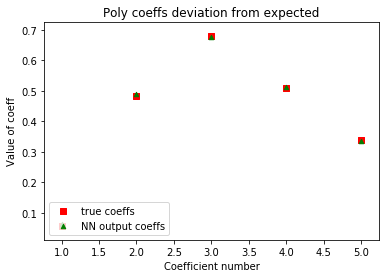

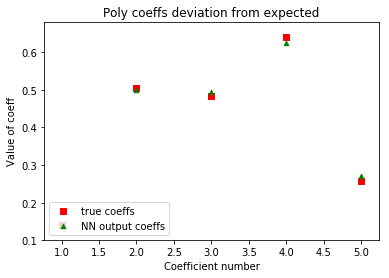

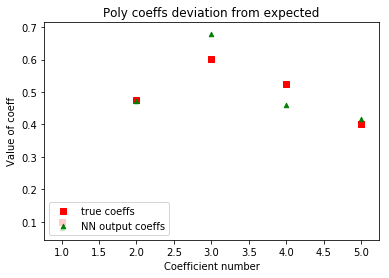

In [28]:
print("Validation Examples")
for NN_idx, valid_idx in enumerate(Idx):
    true_X_coeff_norm = Y_valid_norm[valid_idx,0:5]
    NN_X_coeff_norm = NN_output_norm[NN_idx,0:5]
    plotCoeffsExpectedAndNN(true_X_coeff_norm, NN_X_coeff_norm)
    print("")


# More validation examples

In [45]:
Idx = [61,83,100, 101]
NN_input = np.array(X_valid_norm)
NN_output_norm = model.predict(NN_input[Idx])
NN_output = NN_output_norm*yRange + yMin


In [48]:
print(np.shape(Y_valid_norm))

(1130, 95)


In [46]:
stPoints = (NN_input[Idx][:,0:3])*xRange[0:3] + xMin[0:3]
endPoints = NN_input[Idx][:,13:16]*xRange[0:3] + xMin[0:3]
print(stPoints)
print(endPoints)

[[4.44444444 8.88888889 0.5       ]
 [0.5        6.125      0.5       ]
 [1.375      8.         0.5       ]
 [0.9375     8.         0.5       ]]
[[10.          7.77777778  0.5       ]
 [ 9.          2.75        0.5       ]
 [ 5.5         4.4375      0.5       ]
 [ 7.5         2.1875      0.5       ]]


Validation Examples


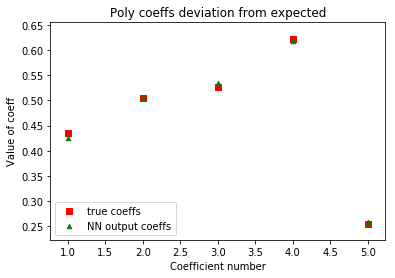

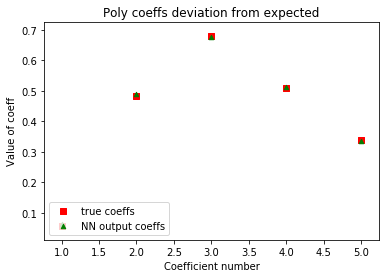

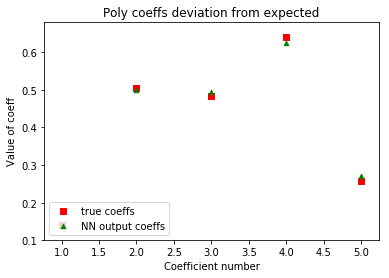

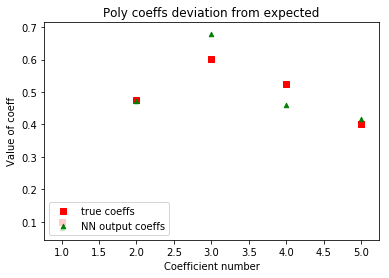

In [28]:
print("Validation Examples")
for NN_idx, valid_idx in enumerate(Idx):
    true_X_coeff_norm = Y_valid_norm[valid_idx,0:5]
    NN_X_coeff_norm = NN_output_norm[NN_idx,0:5]
    plotCoeffsExpectedAndNN(true_X_coeff_norm, NN_X_coeff_norm)
    print("")


# Validation errors

In [57]:
# Idx = [61,83,100, 101]
NN_input = np.array(X_valid_norm)
NN_output_norm = model.predict(NN_input)
NN_output = NN_output_norm*yRange + yMin
NN_coeffs = NN_output
print(np.shape(NN_coeffs))
poly_coeffs = Y_valid
print(np.shape(poly_coeffs))

(1130, 95)
(1130, 95)


In [47]:
def recoverXUfromCoeffs(coeffs)
    N = 50
    tf_guess = 110.
    t_array = range(0,stop=tf_guess,length=N)
    t_minus_one_array = t_array[1:end-1]
    num_coeffs = 5
    x_dim = 13
    u_dim = 6
    
    X_soln = np.zeros(x_dim, N)
    U_soln = np.zeros(u_dim, N-1)
    
    for dim = 1:x_dim
        cf_this = coeffs[((dim-1)*num_coeffs): (dim*num_coeffs-1)]
        this_poly = polyval(Poly(cf_this), t_array)
        X_soln[dim, :] = this_poly
    end
    
    for dim = 1:u_dim
        cf_this = coeffs[(x_dim*num_coeffs + (dim-1)*num_coeffs + 1): (x_dim*num_coeffs + dim*num_coeffs)]
        this_poly = polyval(Poly(cf_this), t_minus_one_array)
        U_soln[dim, :] = this_poly
    end
    
    return X_soln, U_soln
end

recoverXUfromCoeffs (generic function with 1 method)